In [3]:
#V.1

import matplotlib.pyplot as plt
import pandas as pd

# white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def plot_scatter_matrix(wine_data: pd.DataFrame, good_threshold: int, bad_threshold: int, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce graphs which shows dependence between
    every two factors.
    """
    assert good_threshold > bad_threshold, "Please, enter good_treshold sctrictly > than bad_treshold"
    q = wine_data['quality']    

    labels = wine_data.columns[:-1]
    assert len(labels) >=2, "there have to be at least 2 labels ti build dependence"
    f, axarr = plt.subplots(len(labels), len(labels), figsize=(20, 20))
    f.suptitle('Dependence between acidity and quality')
    f.subplots_adjust(wspace=0, hspace=0)

    k = 0
    for x in [wine_data[label] for label in labels]:
        j = 0
        for y in [wine_data[label] for label in labels]:
            axarr[k][j].set_xticks([])
            axarr[k][j].set_yticks([])
            if k == j:
                axarr[k][j].text(0.1, 0.5, labels[k], fontsize=11)
            else:
                colors = [('orchid' if q[i]<= bad_threshold else ('green' if q[i]>=good_threshold else 'None'))\
                          for i in range(wine_data.shape[0])]
                axarr[k][j].scatter(x, y, marker='.', c=colors)
            j+=1
        k+=1
    plt.savefig('fig.png') if save_plot else 0
    return     

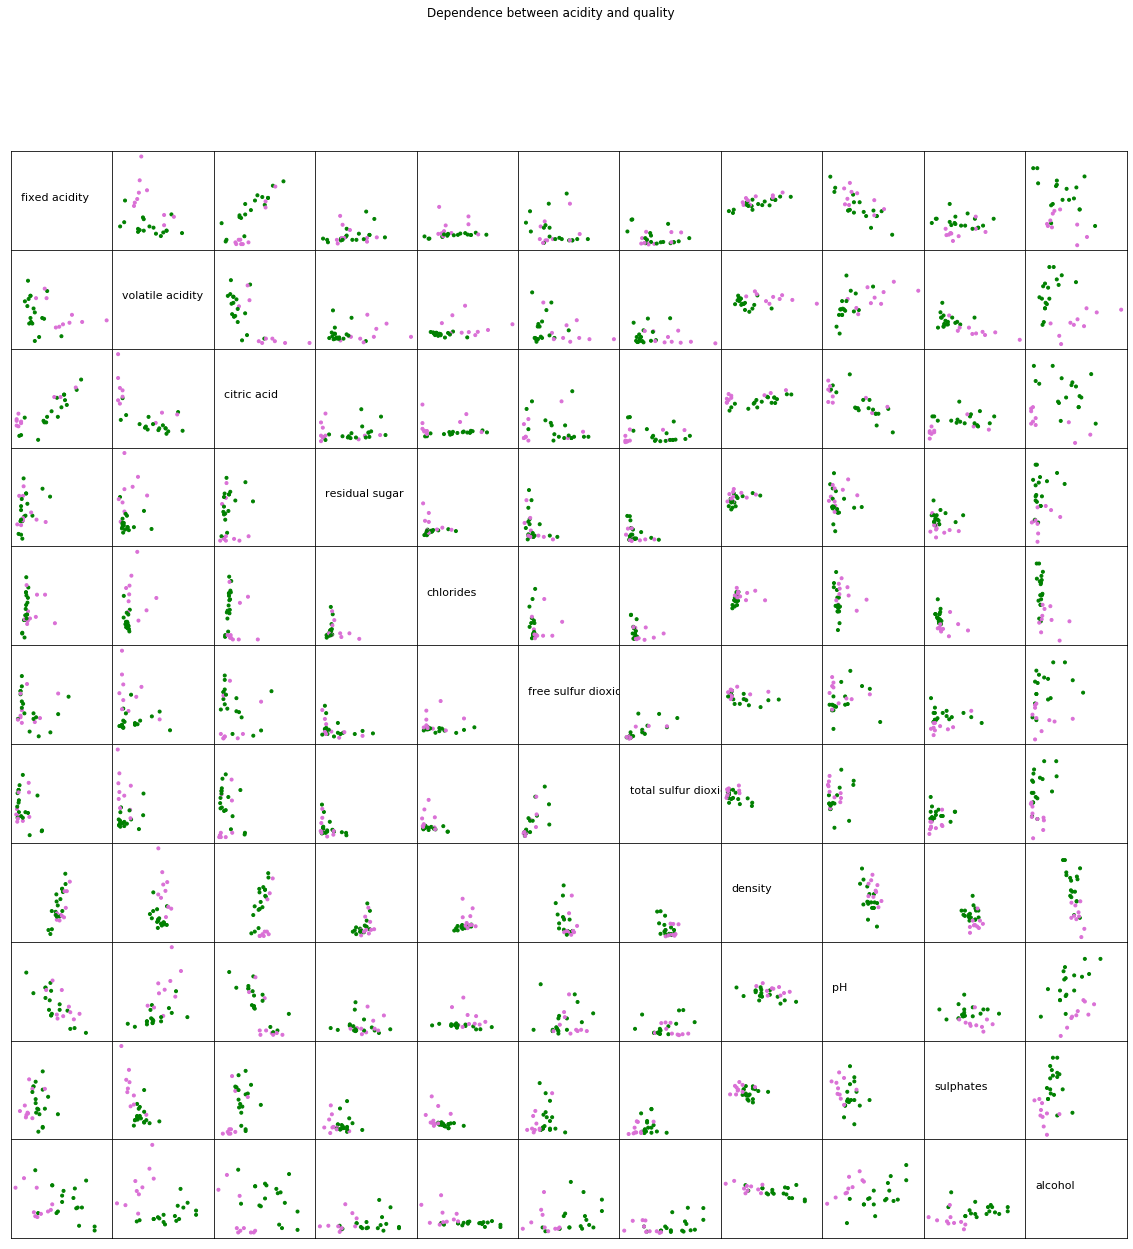

In [2]:
plot_scatter_matrix(red_df, 8, 3, False)

# Important chemical factors: volatile acidity, sulfates, alcohol. 
# Basically we can divide almost strictly bad and good wines considering them.

In [4]:
def feature_scaling(x: pd.DataFrame):
    print('Feature scaling is on.')
    means, maxs, mins = {}, {}, {}
    for feature in x.columns[:-1]:
        means[feature] = sum(x[feature]) / len(x[feature])
        maxs[feature] = max(x[feature])
        mins[feature] = min(x[feature])
    
    scaled_x = x.copy(deep=True)
    for feature in scaled_x.columns[:-1]:
        for j in range(len(scaled_x[feature])):
            scaled_x.loc[j, feature] = (x[feature][j] - means[feature]) / (maxs[feature] - mins[feature])
    print('Data scaled.')
    return scaled_x

In [80]:
# V.2

from math import exp
import random
random.seed(1777)

def inf():
    i = 0
    while True:
        yield i
        i += 1

def dot(a: list, b: list) -> float:
    """
    Scalar product of 2 vectors a and b
    """
    assert len(a) == len(b), "Vectors must be equal length!"
    return sum([a[i] * b[i] for i in range(len(a))])

class Perceptron(object):

    def __init__(self, threshold, learning_rate =0.4, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs 
        self.res = []
        self.threshold = threshold
        return
    
    def error(self, y: list, d: list) -> int:
        return sum(abs(d-y))

    def train(self, x: list, d: list): 
        """
        train perceptron on received data
        x - received data (matrix, row - one specific wine)
        d - desired output (good(1) or bad(0) wines good=(quality>threshold))
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))]
        self.bias = random.random()
        y = [int(random.random() > 0.5) for _ in range(len(x))]
        self.res.append([0, self.error(y, d), self.w, self.bias])
        for i in inf() if self.epochs == 0 else range(self.epochs):
            for row in range(len(x)):
                y[row] = int(dot(x[row], self.w) + self.bias >= self.threshold)
                error = d[row] - y[row]
                for col in range(len(x[row])):
                    self.w[col] += self.learning_rate * error * x[row][col]
                self.bias += self.learning_rate * error
            self.res.append([i, self.error(y, d), self.w, self.bias])
            if self.epochs == 0 and self.res[-1][1] == 0:
                break
        return
    
    def predict(self, x):
        return int(dot(self.w, x) + self.bias >= self.threshold)

    
def plot_cost(performance, epoch, ax):
    if epoch < 0 or epoch > performance[-1][0]:
        print(f'epoch was : {epoch}')
        epoch = performance[-1][0]
    errors = [performance[i][1]  for i in range(len(performance))]
    epochs = [performance[i][0]  for i in range(len(performance))]
    ax.plot(epochs, errors, c='b')
    ax.set_xlabel('iterations')
    ax.set_ylabel('cost')
    ax.set_title('Errors as a function of epochs')
    return
    
pink, green = (0.976, 0.854, 0.992), (0.866, 0.921, 0.854)
def plot_performance(performance, wine_data, good_thresh, bad_thresh, factors: list, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    plot_cost(performance, epoch, ax[0])
    
    b = performance[epoch][3]
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    assert w2 != 0, "w2 = 0"
    f1 = [i for i in range(-50, 50)]
    f2 = [ (good_thresh - b - w1 * f1[j]) / w2 for j in range(len(f1))]

    ax[1].set_xlim(min(wine_data[factors[0]].values)-0.1, max(wine_data[factors[0]].values)+0.1)
    ax[1].set_ylim(min(wine_data[factors[1]].values)-0.1, max(wine_data[factors[1]].values)+0.1)
    ax[1].plot(f1, f2, linestyle='--', color='b', label='Decision Boundary')
   
    goods = wine_data[wine_data.quality >= good_thresh]
    bads = wine_data[wine_data.quality <= bad_thresh]
    xg, yg = goods[factors[0]].values, goods[factors[1]].values
    xb, yb = bads[factors[0]].values, bads[factors[1]].values

    # count good dots and define how to fill the field
    right_color, left_color = green, pink
    upper_dots = 0
    for xi, yi in zip(xb, yb):
        if (good_thresh - b - w1 * xi) / w2 < yi:
            upper_dots += 1
    if upper_dots > len(xb) / 2:
        right_color, left_color = pink, green
    
    ax[1].fill_between(f1, f2, max(f1)+5, facecolor=right_color)
    ax[1].fill_between(f1, f2, min(f1)-5, facecolor=left_color)
    ax[1].scatter(xg, yg, marker='.', c='green', label=f'good wines(>{good_thresh-1} score)')
    ax[1].scatter(xb, yb, marker='.', c='orchid', label=f'bad wines(<{bad_thresh+1} score)')
    ax[1].set_title(f'Decision boundary on epoch {epoch}')
    ax[1].set_xlabel(factors[0]) 
    ax[1].set_ylabel(factors[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    print(f'b = {round(b,1)}, w1 = {round(w1, 1)}, w2 = {round(w2, 1)},\
    x2 = {round((good_thresh - b)/w2,2)}-x1*{round(w1/w2,2)}')
    plt.show()
    return
# V.2.end

Feature scaling is on.
Data scaled.
b = 8.1, w1 = 1.3, w2 = -1.4,    x2 = 0.04-x1*-0.99


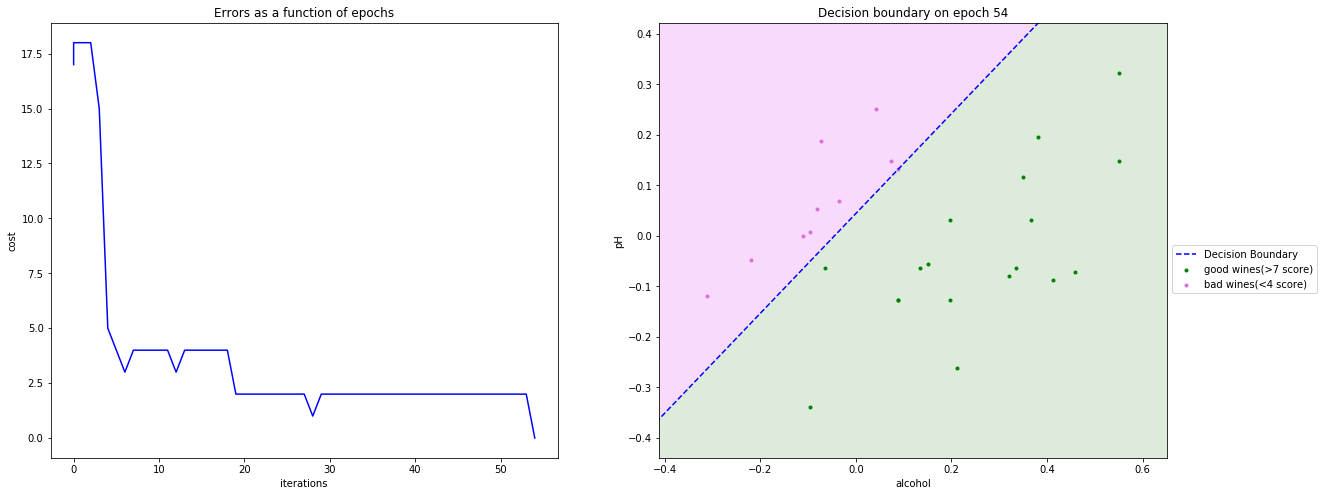

In [10]:
def prepare_data_and_train(wine_data: pd.DataFrame, learning_rate, \
                           factors: list, wines_threshs: list, epochs: int):
    perceptron = Perceptron(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality <= wines_threshs[0]) | (wine_data.quality >= wines_threshs[1])]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= wines_threshs[1]).astype(int)
    perceptron.train(x, d)
    plot_performance(perceptron.res, part, wines_threshs[1], wines_threshs[0], factors, perceptron.res[-1][0])
    return


red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 
# prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# feature scaling
red_df = feature_scaling(red_df)
prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# prepare_data_and_train(red_df, 0.1, ['chlorides', 'sulphates'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['volatile acidity', 'alcohol'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.01, ['density', 'volatile acidity'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['density', 'volatile acidity'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [4, 7], 15000)

In [11]:
# V.3
class Adaline(object):

    def __init__(self, threshold, learning_rate=0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        self.w = []
        return
 
    def error(self, y: list, d: list) -> float:
        r = 0
        for i in range(len(d)):
            r += (d[i] - y[i]) * (d[i] - y[i])
        r = r / 2
        return r

    def do_step_batch(self, x, y, d):
        """
        update weights for each row once (batch)
        """
        for row in range(len(x)):
            updates = [0 for i in range(len(x[0]))]
            bias_update = 0
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                updates[col] += self.learning_rate * error * x[row][col]
            bias_update += self.learning_rate * error
        self.bias += bias_update
        for col in range(len(x[row])):
            self.w[col] += updates[col]
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
    
    def do_step_online(self, x, y, d):
        """
        update weights for each row once (batch)
        """        
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * error * x[row][col]
            self.bias += self.learning_rate * error
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
          
    def train(self, x: list, d: list, online=True, reinitialize_weights=True):
        """
        train adaline on received data
        x - received data (matrix, row - one specific wine)
        d - desired output
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        if len(self.w) != len(x[0]) or reinitialize_weights:
            self.w = [random.random() for i in range(len(x[0]))]
            self.bias = random.random()
        y = [random.random() * 10 for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        step = self.do_step_online if online else self.do_step_batch
        for i in inf() if self.epochs == 0 else range(self.epochs):
            step(x, y, d)
            if self.epochs == 0 and i > 2 and abs(self.res[-2][1]) < abs(self.res[-1][1]):
                break
        print(f'Learning rate: {self.learning_rate}, cost/rows: {self.res[-1][1] / len(x)}')
        return
    
    def predict(self, x):
        return dot(self.w, x) + self.bias
# V.3 _end_  

Learning rate: 0.001, cost/rows: 0.5898158218974177
b = 5.8, w1 = 4.7, w2 = -4.0,    x2 = -0.31-x1*-1.18


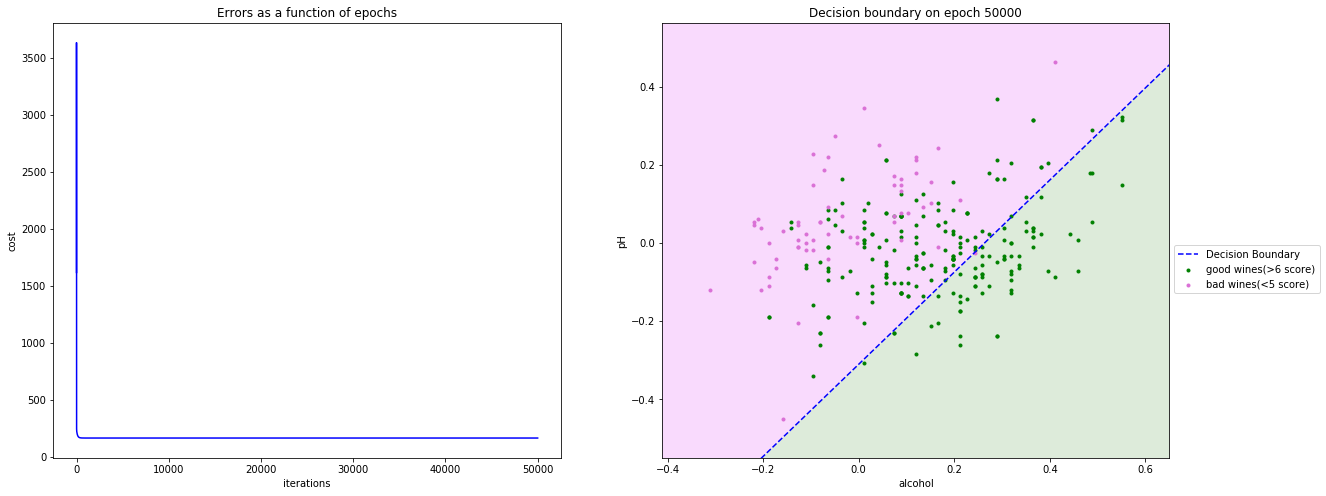

In [12]:
   def prepare_data_and_train_ada(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality >= wines_threshs[1]) | (wine_data.quality <= wines_threshs[0])]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    plot_performance(ada.res, part, wines_threshs[1], wines_threshs[0], factors, ada.current_epoch)
    return

learning_rate, online = 0.01, True

# showtime
# prepare_data_and_train_ada(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [3, 8], 4)

# prepare_data_and_train_ada(red_df, 0.01, ['alcohol', 'pH'], [4, 7], 10000, online)
prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 50000, online)
# prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [4, 7], 10000, online)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 10000, False)

Learning rate: 0.01, cost/rows: 0.6361562199642887
b = 5.8, w1 = -3.7, w2 = 4.3,    x2 = 0.27-x1*-0.87


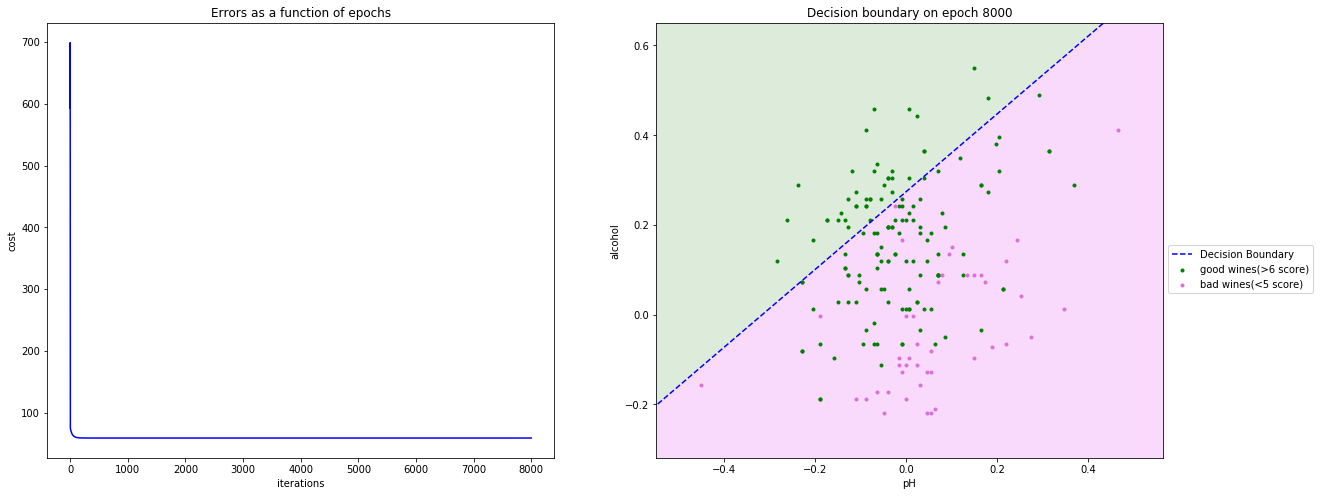

learning rate: 0.01, cost = 59.16252845667885
Learning rate: 0.001, cost/rows: 0.6517876287098152
b = 5.8, w1 = -3.7, w2 = 4.9,    x2 = 0.23-x1*-0.75


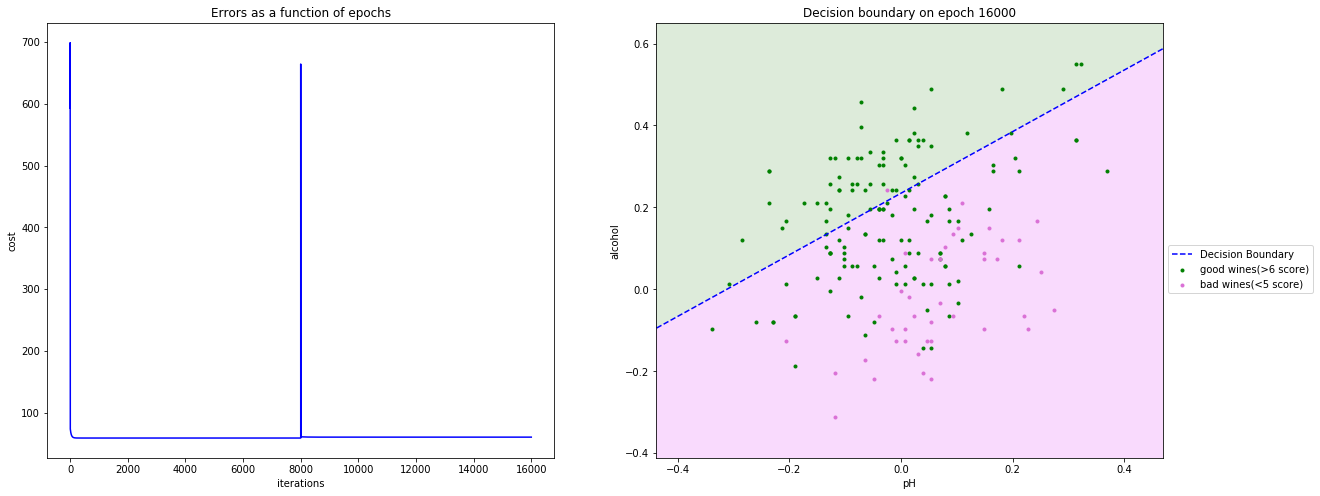

learning rate: 0.001, cost = 60.61624947001281
Learning rate: 0.0001, cost/rows: 0.47366387207595856
b = 5.7, w1 = -4.3, w2 = 5.0,    x2 = 0.27-x1*-0.86


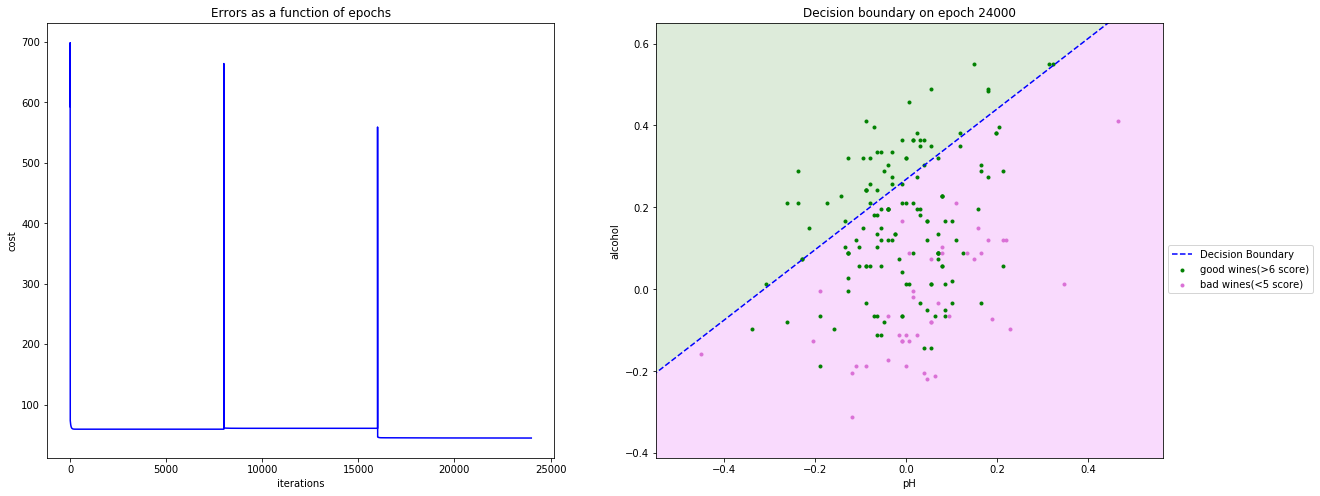

learning rate: 0.0001, cost = 44.5244039751401
Best(lr: 0.0001): w1 = -4.3 w2 = 5.0, bias = 4.1
b = 5.7, w1 = -4.3, w2 = 5.0,    x2 = 0.27-x1*-0.86


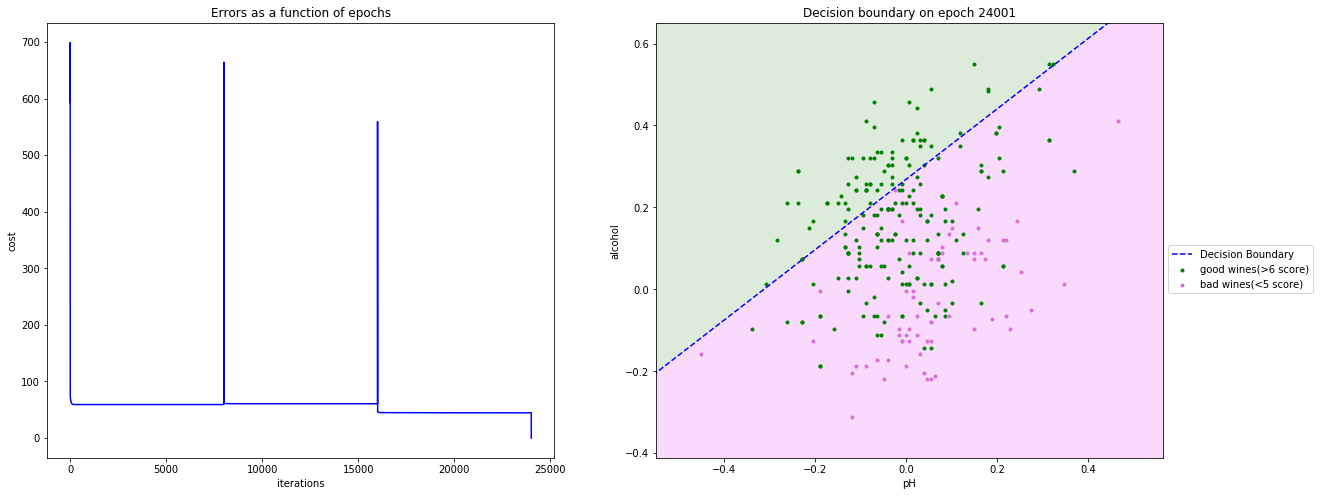

In [13]:
# V.4

def holdout(wine_data: pd.DataFrame, limits, train_part=0.8):
    wine_data = wine_data[(wine_data.quality >= limits[1]) | (wine_data.quality <= limits[0])]
    train_amount = int(wine_data.shape[0] * train_part)
    shuffled_data = wine_data.sample(frac=1)
    return (shuffled_data[:train_amount], shuffled_data[train_amount:])


def k_fold(wine_data: pd.DataFrame, k=3, shuffle=False):
    wine_data = wine_data[(wine_data.quality <= 4) | (wine_data.quality >= 7)]
    if shuffle:
        wine_data = wine_data.sample(frac=1, random_state=1, axis=0)
    folds = []
    rest = wine_data
    amount = int(wine_data.shape[0] / k)
    res = []
    for i in range(k-1):
        training_temp = rest.sample(n=amount)
        folds.append(training_temp)
        rest = rest.drop(training_temp.index) 
        res.append([folds[i], wine_data.drop(folds[i].index)])
    res.append([rest, wine_data.drop(rest.index)]) # (trainig, validation)
    return res


def training(data, k):
#     tuples = [holdout(red_df, [4, 7])]
    tuples = k_fold(data, k)
    weight_list = [] # tuples [w, bias]
    ada = Adaline(7, 0.01, 8000)
    costs = []
    lr = []
    
    for t in tuples:
        tr, val = t[0], t[1]
        tr.index, val.index = range(len(tr)), range(len(val))
        x = tr[['pH', 'alcohol']].values
        d = tr['quality']
        ada.train(x, d, True, False)
        plot_performance(ada.res, val, 7, 4, ['pH', 'alcohol'], ada.current_epoch)
        weight_list.append([ada.res[-1][2], ada.res[1][3]])
        costs.append(ada.res[-1][1])
        lr.append(ada.learning_rate)
        print(f'learning rate: {lr[-1]}, cost = {costs[-1]}')
        ada.learning_rate *= 0.1
        
    ind = costs.index(min(costs))
    weight1 = weight_list[ind][0][0]
    weight2 = weight_list[ind][0][1]
    bias = weight_list[ind][1]
    print(f'Best(lr: {lr[ind]}): w1 = {round(weight1, 1)} w2 = {round(weight2, 1)}, bias = {round(bias, 1)}')
    ada.res.append([ada.res[-1][0]+1, 0, [weight1, weight2], bias])
    part = data[(data.quality >= 7) | (data.quality <= 4)]
    plot_performance(ada.res, part, 7, 4, ['pH', 'alcohol'], ada.current_epoch + 1)

training(red_df, 3)
    

In [ ]:
# V.5
print(f'types: {red_df.columns}')

def multi_factors(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality >= wines_threshs[1]) | (wine_data.quality <= wines_threshs[0])]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_cost(ada.res, ada.res[-1][0], ax)
    return

multi_factors(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['alcohol', 'pH', 'volatile acidity'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['fixed acidity', 'volatile acidity', 'citric acid'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['sulphates', 'alcohol', 'quality'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['density', 'alcohol', 'chlorides'], [4, 7], 9000, True)
# V.5

In [126]:
# V.6.v1
from matplotlib.patches import Ellipse
import math

df = pd.read_csv("resources/Pan Galactic Gargle Blaster.csv", sep=";")
# df = feature_scaling(df)

ppn = Perceptron(9, 0.01, 0)
factors =  [df.columns[0], df.columns[1]]
part = df[(df.quality <= 1) | (df.quality >= 9)]
part.index = range(len(part))
x = part[factors].values.tolist()
x1_sq = [(x[i][0])**2 for i in range(len(x))]
x2_sq = [(x[i][1])**2 for i in range(len(x))]
for j in range(len(x)):
    x[j].append(x[j][0]**2)
    x[j].append(x[j][1]**2)
d = (part['quality'] >= 9).astype(int)
ppn.train(x, d)

b = -134.2009022503725, w1 = 31.025536762933154, w2 = 34.341166790892686, w1sq =-3.7634386804857085, w2sq= -4.11660412346513


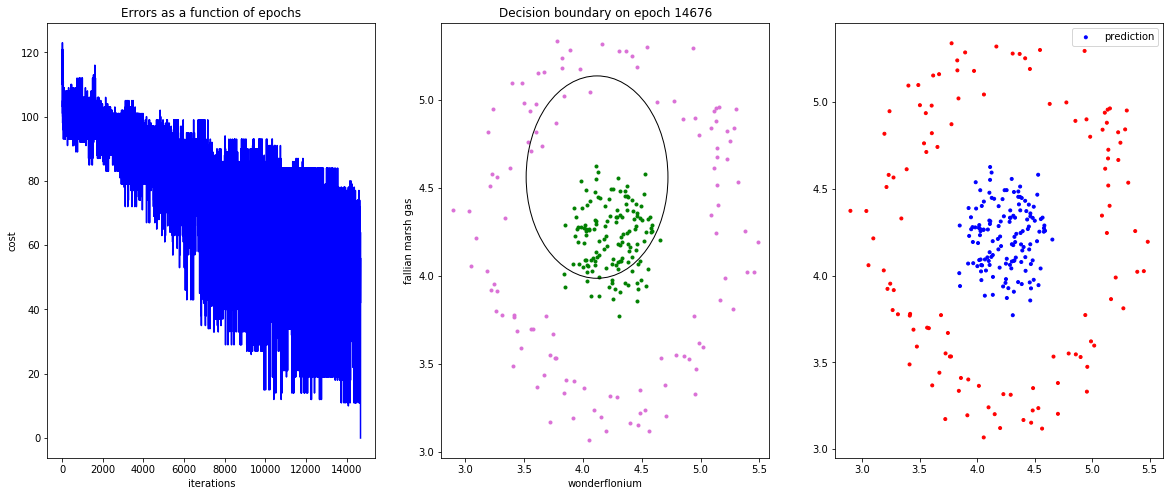

In [134]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))
plot_cost(ppn.res, ppn.res[-1][0], ax[0])

b = ppn.res[-1][3] - 9
w1 = ppn.res[-1][2][0]
w2 = ppn.res[-1][2][1]
w1sq = ppn.res[-1][2][2]
w2sq = ppn.res[-1][2][3]
print(f'b = {b}, w1 = {w1}, w2 = {w2}, w1sq ={w1sq}, w2sq= {w2sq}')

x0 = -w1/(2*w1sq)
y0 = -w2/(2*w1sq)
width_ = math.sqrt( ((w1**2)/(4*w1sq) + (w2**2)/(4*w2sq) - b) / w1sq  )
height_ = math.sqrt( ((w1**2)/(4*w1sq) + (w2**2)/(4*w2sq) - b) / w2sq )
ellipse = Ellipse((x0, y0), width=width_*2, height=height_*2, edgecolor='k', facecolor='none')
ax[1].add_artist(ellipse)

ax[1].set_xlim(min(part[factors[0]].values)-0.1, max(part[factors[0]].values)+0.1)
ax[1].set_ylim(min(part[factors[1]].values)-0.1, max(part[factors[1]].values)+0.1)

bads = df[df.quality <= 1]
xb, yb = bads["wonderflonium"].values, bads["fallian marsh gas"].values
goods = df[df.quality >= 9]
xg, yg = goods["wonderflonium"].values, goods["fallian marsh gas"].values

ax[1].scatter(xg, yg, marker='.', c='green', label=f'good wines(>={9} score)')
ax[1].scatter(xb, yb, marker='.', c='orchid', label=f'bad wines(<{9} score)')
ax[1].set_title(f'Decision boundary on epoch {ppn.res[-1][0]}')
ax[1].set_xlabel(factors[0])
ax[1].set_ylabel(factors[1])
    
x_all = part["wonderflonium"].values
y_all = part["fallian marsh gas"].values
colors = []
for j in range(len(x_all)):
    color = 'b' if ppn.predict(x[j]) else 'r'
    colors.append(color)
ax[2].scatter(x_all, y_all, marker='.', c=colors, label=f'prediction')
plt.legend()
plt.show()

# V.6.v1.end

VI.2 Do perceptrons dream of electric sheep?

Peer into the decision making process of your perceptrons and ADALINEs!
Create animated plots of errors as a function of epoch and the changing decision boundary of 
your perceptron and/or ADALINE as a function of epoch. Each time step in your
animation should be equivalent to advancing the training epoch by 1!
You’ll probably want to do some googling on matplotlib animations in
jupyter...The dockerized jupyter environment comes with everything
you need to get animations working though! They’re “libav-tools” and
“ffmpeg” if you’re curious...

VI.3 Dimensional traveler

Create a function that can plot the decision boundary when you train your perceptron
or ADALINE on 3 different factors! Your plot will of course need to plot the actual wine
data points in 3-factor space as well!
Did you know that matplotlib can create 3D plots?